## Importing Libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os


Using TensorFlow backend.


## Loading the Data

In [2]:
def load_split(csvPath):
    data = []
    labels = []

    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)

    for (i, row) in enumerate(rows):
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))
            
        (label, imagePath) = row.strip().split(",")[-2:]

        imagePath =  "dataset/" + imagePath
        image = io.imread(imagePath)

        # Since it is given the problem statement, images can be of very low contrast
        # we will perform Contrast Limited Adaptive Histogran Equalization (CLAHE) to handle such problem
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        data.append(image)
        labels.append(int(label))

    data = np.array(data)
    labels = np.array(labels)

    return (data, labels)

In [6]:
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [7]:
trainPath = "dataset/Train.csv"
testPath = "dataset/Test.csv"

In [8]:
(trainX, trainY) = load_split("dataset/", trainPath)
(testX, testY) = load_split("dataset/", testPath)

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

### Normalizing the images

In [107]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

### One-hot encode the training and testing labels

In [10]:
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

### Define Class Weights

In [41]:
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

### Define Image Data Generator

In [11]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

### Initialize Variables

In [19]:
epoch = 30
lr = 1e-3
batch_size = 64

## Define Model Architecture

In [23]:
from keras.models import Sequential
from keras.layers import *
def build_model(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # CONV => RELU => BN => POOL
    model.add(Conv2D(8, (5, 5), padding="same",
        input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # second set of FC => RELU layers
    #model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model

## Compile the Model

In [94]:
model = build_model(width=32, height=32, depth=3,classes=numLabels)
opt = Adam(lr=lr, decay=lr / (epoch * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [95]:
from keras.callbacks.callbacks import ModelCheckpoint
filepath="model/model{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [96]:
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // batch_size,
    epochs=epoch,
    class_weight=classWeight,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/30
612/612 [==============================] - 61s 99ms/step - loss: 2.5725 - accuracy: 0.3138 - val_loss: 2.7469 - val_accuracy: 0.2562

Epoch 00001: val_accuracy improved from -inf to 0.25622, saving model to model/model01-0.26.h5
Epoch 2/30
612/612 [==============================] - 56s 91ms/step - loss: 1.2865 - accuracy: 0.5871 - val_loss: 0.6673 - val_accuracy: 0.7718

Epoch 00002: val_accuracy improved from 0.25622 to 0.77181, saving model to model/model02-0.77.h5
Epoch 3/30
612/612 [==============================] - 56s 91ms/step - loss: 0.8605 - accuracy: 0.7221 - val_loss: 0.5557 - val_accuracy: 0.8208

Epoch 00003: val_accuracy improved from 0.77181 to 0.82082, saving model to model/model03-0.82.h5
Epoch 4/30
612/612 [==============================] - 57s 92ms/step - loss: 0.6512 - accuracy: 0.7893 - val_loss: 0.4727 - val_accuracy: 0.8434

Epoch 00004: val_accuracy improved from 0.82082 to 0.84339, saving model to model/model04-0.84.h5
Epoch 5/30
612/612 [===========

best model was found at epoch number 10

### Load the best model

In [120]:
from keras.models import load_model
model = load_model('model/model11-0.94.h5')

## Results

In [121]:
predictions = model.predict(testX)
predictions = predictions.argmax(axis=1)

In [122]:
from sklearn.metrics import accuracy_score
accuracy_score(testY.argmax(axis=1), predictions)

0.9404592240696754

In [123]:
print(classification_report(testY.argmax(axis=1), predictions, target_names=labelNames))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.90      0.93      0.92        60
                              Speed limit (30km/h)       0.98      0.97      0.97       720
                              Speed limit (50km/h)       0.91      0.98      0.94       750
                              Speed limit (60km/h)       0.89      0.95      0.92       450
                              Speed limit (70km/h)       0.98      0.96      0.97       660
                              Speed limit (80km/h)       0.92      0.86      0.89       630
                       End of speed limit (80km/h)       0.85      0.94      0.90       150
                             Speed limit (100km/h)       0.94      0.90      0.92       450
                             Speed limit (120km/h)       0.89      0.95      0.92       450
                                        No passing       0.98      0.97      0.

### Print Loss/Accuracy measurnments

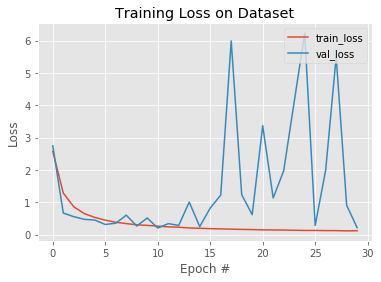

In [114]:
# plot the training loss and accuracy
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("output/loss_plot.png")

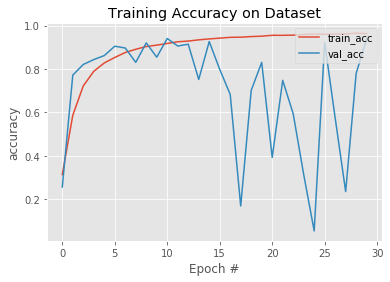

In [115]:
# plot the training loss and accuracy
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.savefig("output/accuracy_plot.png")